In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import contractions
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import spacy

# Load Spacy model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df = pd.read_csv("/kaggle/input/emotions/text.csv")

In [7]:
df

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [8]:
df = df[['label', 'text']]

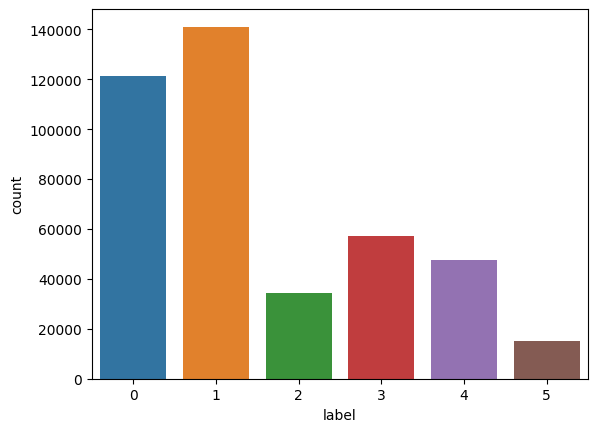

In [9]:
sns.countplot(x='label', data=df)
plt.show()

In [10]:

stop_words = set(stopwords.words('english'))
stop_words.discard('not')

def clean_text(text):
    
    text = text.lower()
    text =  re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'&\w+', '', text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\bs\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
#     doc = nlp(text)
#     lemmatized_words = [token.lemma_ for token in doc]
#     filtered_words = [word for word in text.split() if word not in stop_words]

    return ' '.join(filtered_words)

In [11]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [12]:
def generate_wordcloud(text):
    return WordCloud(width=800, height=400, background_color='white').generate(text)

def plot_wordclouds(df, text_column, class_column):
    classes = df[class_column].unique()
    num_classes = len(classes)

    cols = 2 
    rows = (num_classes + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    for i, class_label in enumerate(classes):
        class_text = ' '.join(df[df[class_column] == class_label][text_column])
        wordcloud = generate_wordcloud(class_text)

        ax = axes[i // cols, i % cols]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Class {class_label}', fontsize=20)

    # Remove empty subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols, j % cols])

    plt.tight_layout()
    plt.show()

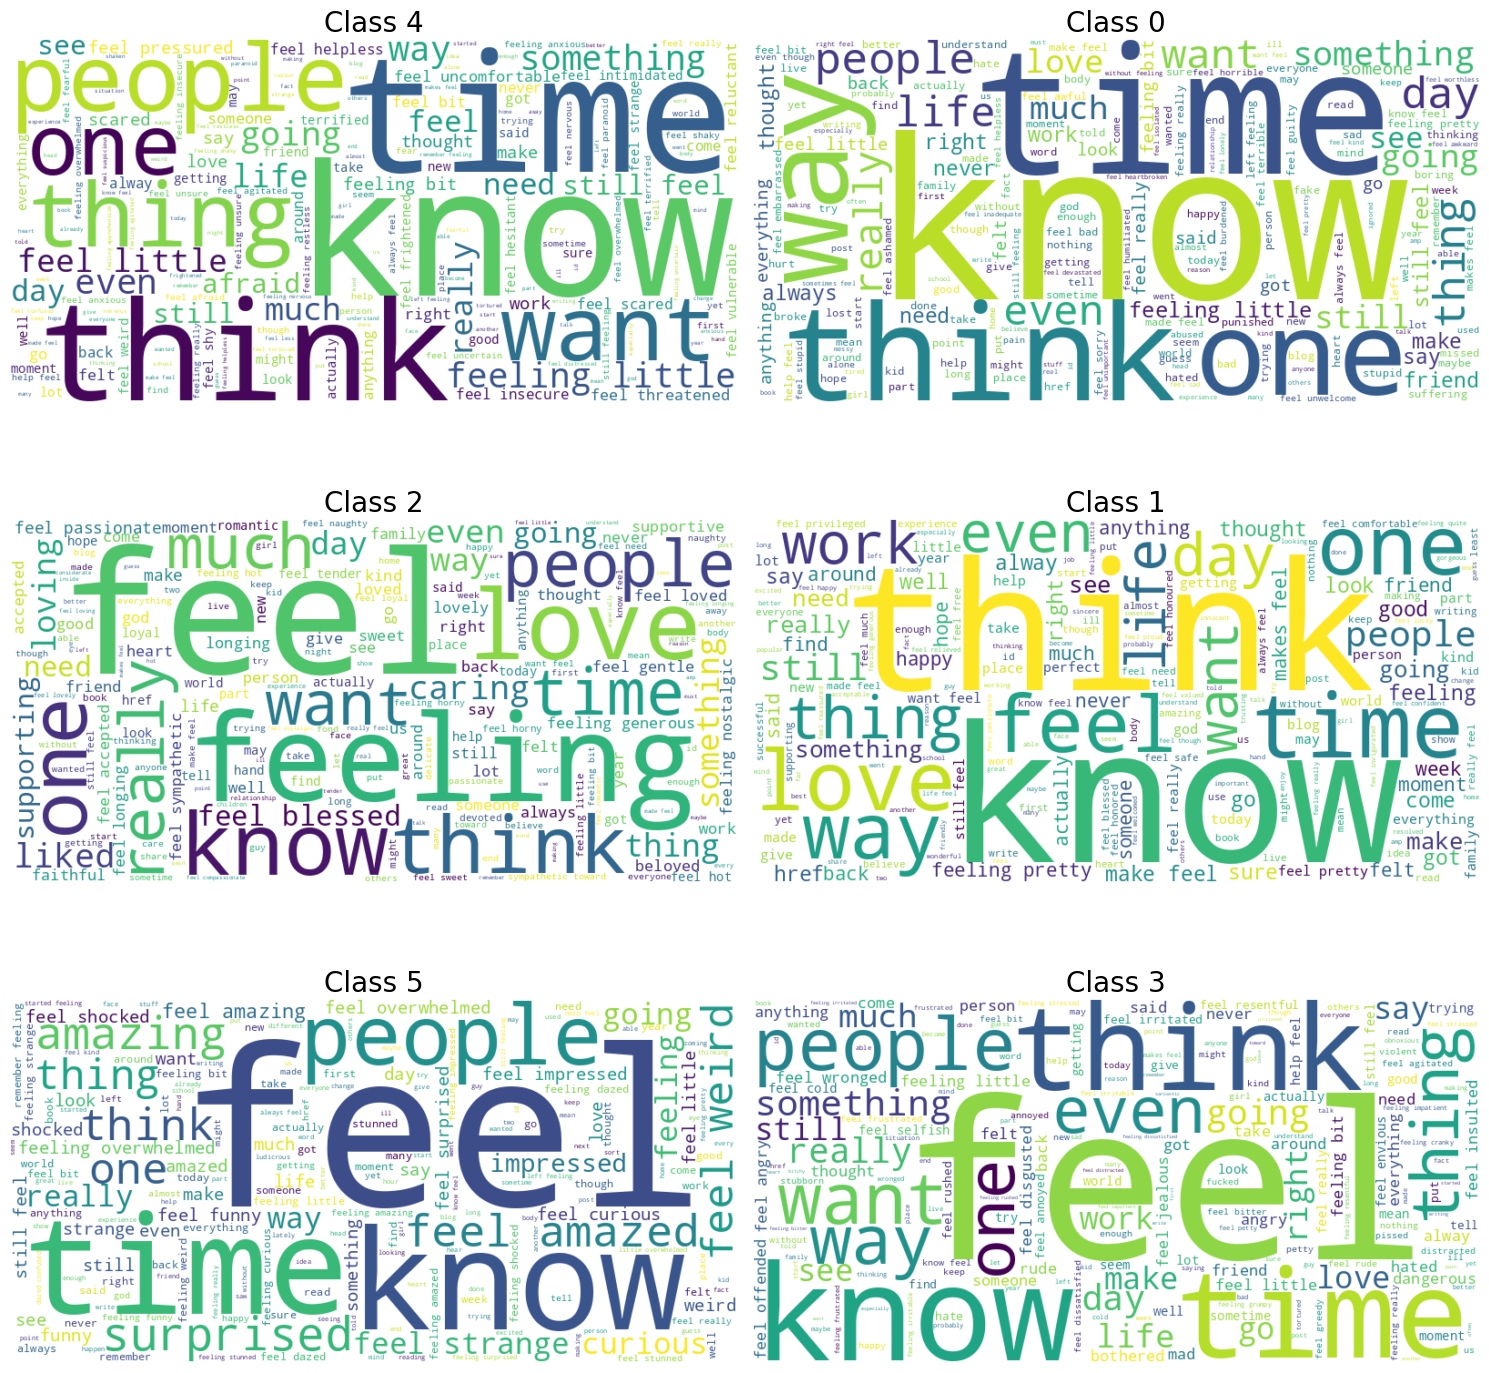

In [13]:
plot_wordclouds(df, 'cleaned_text', 'label')

In [14]:
df = df.drop_duplicates()

In [15]:
X = df['cleaned_text']
y = df['label']

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [18]:
max([len(seq) for seq in train_sequences])

82

In [19]:
max_length = 82

train_sequences_padded = pad_sequences(train_sequences, maxlen=max_length, padding='pre')
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_length, padding='pre')

In [20]:
input_size = np.max(train_sequences_padded) + 1

In [21]:
model = Sequential()
model.add(Input(shape=(82,)))
model.add(Embedding(input_dim=input_size, output_dim=100))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Bidirectional(LSTM(128, return_sequences = False)))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 82, 100)        │     6,759,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 82, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,389,878 (28.19 MB)

 Trainable params: 7,389,878 (28.19 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(train_sequences_padded, y_train, 
                    epochs=15, 
                    batch_size=32, 
                    validation_data=(test_sequences_padded, y_test),
                    callbacks=[EarlyStopping(patience=3)])

Epoch 1/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 221s 21ms/step - accuracy: 0.8704 - loss: 0.3056 - val_accuracy: 0.9413 - val_loss: 0.0924
Epoch 2/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 217s 21ms/step - accuracy: 0.9414 - loss: 0.0918 - val_accuracy: 0.9416 - val_loss: 0.0913
Epoch 3/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 218s 21ms/step - accuracy: 0.9423 - loss: 0.0858 - val_accuracy: 0.9405 - val_loss: 0.0928
Epoch 4/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 216s 21ms/step - accuracy: 0.9443 - loss: 0.0820 - val_accuracy: 0.9412 - val_loss: 0.0912
Epoch 5/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 219s 21ms/step - accuracy: 0.9438 - loss: 0.0805 - val_accuracy: 0.9404 - val_loss: 0.0936
Epoch 6/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 218s 21ms/step - accuracy: 0.9453 - loss: 0.0800 - val_accuracy: 0.9409 - val_loss: 0.0960
Epoch 7/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 219s 21ms/step - accuracy: 0.9437 - loss: 0.0796 - val_accuracy: 0.9409 - val_loss: 0.0951


In [25]:
model.evaluate(test_sequences_padded, y_test)

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9418 - loss: 0.0931


[0.09505467116832733, 0.9408711194992065]

In [26]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_sequences_padded)
y_pred = np.argmax(y_pred, axis=1)

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


<Axes: >

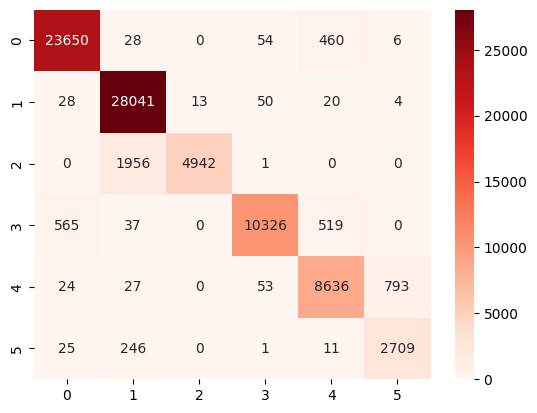

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

In [30]:
model2 = Sequential()
model2.add(Input(shape=(82,)))
model2.add(Embedding(input_dim=input_size, output_dim=100))
model2.add(Bidirectional(GRU(128, return_sequences = True)))
model2.add(Bidirectional(GRU(128, return_sequences = False)))
model2.add(Dropout(0.2))
model2.add(Dense(6, activation='softmax'))

In [31]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model2.fit(train_sequences_padded, y_train, 
                    epochs=15, 
                    batch_size=32, 
                    validation_data=(test_sequences_padded, y_test),
                    callbacks=[EarlyStopping(patience=3)])

Epoch 1/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 220s 21ms/step - accuracy: 0.8890 - loss: 0.2548 - val_accuracy: 0.9399 - val_loss: 0.0980
Epoch 2/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 217s 21ms/step - accuracy: 0.9418 - loss: 0.0972 - val_accuracy: 0.9402 - val_loss: 0.0964
Epoch 3/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 217s 21ms/step - accuracy: 0.9406 - loss: 0.1036 - val_accuracy: 0.9397 - val_loss: 0.1103
Epoch 4/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 218s 21ms/step - accuracy: 0.9417 - loss: 0.0996 - val_accuracy: 0.9387 - val_loss: 0.1005
Epoch 5/15
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 217s 21ms/step - accuracy: 0.9428 - loss: 0.0940 - val_accuracy: 0.9406 - val_loss: 0.0972


2601/2601 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step


<Axes: >

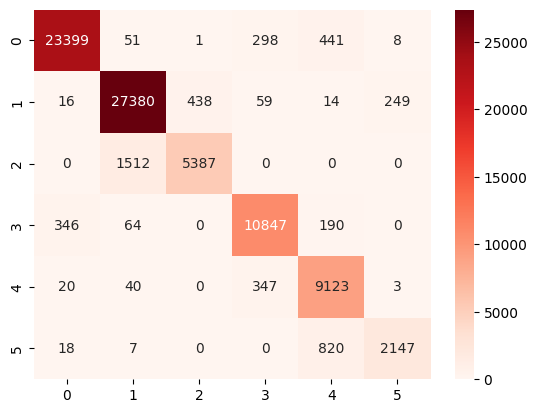

In [33]:
y_pred = model2.predict(test_sequences_padded)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

In [56]:
emotion_map = {
    0 : 'sadness',
    1 : 'joy',
    2 : 'love',
    3 : 'anger',
    4 : 'fear',
    5 : 'surprise'
}

In [154]:
def predict_text(text):
    text = clean_text(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=max_length, padding='pre')
    
    preds = model.predict(text)
    sns.barplot(y=pd.Series(preds[0]), x=np.array(list(emotion_map.values())))
    pred = np.argmax(preds, axis=1)
    
    return emotion_map[pred[0]]
#     return preds

i would certainly feel what im suppose to be feeling which is brave
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'joy'

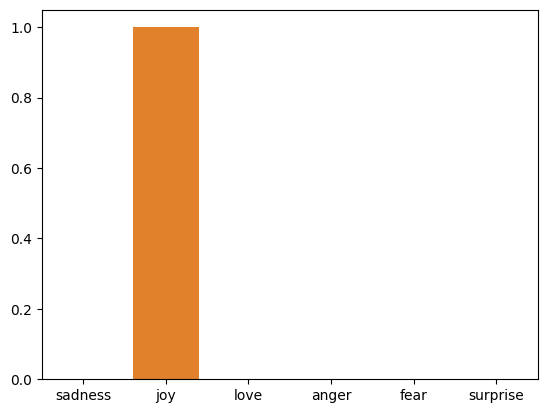

In [170]:
text = df['text'].sample().values[0]
# text = "I know that i have made mistakes, i have let you down. i feel so bad"
print(text)
predict_text(text)